In [ ]:
import pandas as pd
import numpy as np
# from sentence_transformers import SentenceTransformer, models

c:\Users\SURIYA\Desktop\Competition\Sebi-Hackathon-Modules\sebi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_all = pd.read_csv("all_normal_clauses.csv")
print("Total clauses:", len(df_all))

Total clauses: 150881


In [3]:
df_all.head()

,clause_text,clause_type
0,Except as set forth in Section 4.07 of the Dis...,absence-of-certain-changes-or-events
1,"Since March 31, 1997, except as disclosed in ...",absence-of-certain-changes-or-events
2,"(a) Since December 31, 2017, no event or event...",absence-of-certain-changes-or-events
3,Since the date of the Company Balance Sheet th...,absence-of-certain-changes-or-events
4,Except as set forth in the Recent SEC Documen...,absence-of-certain-changes-or-events


In [ ]:
# def clean_clause_text(text):
#     period_index = text.find('.')
#     if period_index != -1:
#         return text[period_index + 1:].lstrip()
#     return text

# df_all['clause_text'] = df_all['clause_text'].apply(clean_clause_text)
# df_all['clause_text'] = df_all['clause_text'].str.replace('------------------------------------', '', regex=False)


In [ ]:
# word_embedding_model = models.Transformer("nlpaueb/legal-bert-base-uncased")
# pooling_model = models.Pooling(
#     word_embedding_model.get_word_embedding_dimension(),
#     pooling_mode_mean_tokens=True
# )
# model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:
# embeddings = model.encode(
#     df_all["clause_text"].tolist(),
#     show_progress_bar=True,
#     normalize_embeddings=True
# )

In [5]:
import os
from huggingface_hub import hf_hub_download, snapshot_download

In [6]:
from dotenv import load_dotenv

In [7]:
load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")

In [8]:
emb_path = hf_hub_download(
    repo_id="SuriyaSureshkumar/sebi-clauses",
    filename="embeddings.npy",
    repo_type="dataset",
    token=HF_TOKEN
)

embeddings = np.load(emb_path)

c:\Users\SURIYA\Desktop\Competition\Sebi-Hackathon-Modules\sebi\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\SURIYA\.cache\huggingface\hub\datasets--SuriyaSureshkumar--sebi-clauses. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [9]:
clauses = df_all["clause_text"].astype(str).tolist()
clause_types = df_all["clause_type"].astype(str).tolist()

In [ ]:
local_dir = snapshot_download(
    repo_id="SuriyaSureshkumar/sebi-clauses",
    repo_type="dataset",
    token=HF_TOKEN
)

In [10]:
import chromadb

client = chromadb.PersistentClient(path="vector_db/chroma_legal_db")
collection = client.get_or_create_collection(
    name="legal_clauses",
    metadata={"hnsw:space": "cosine"}
)

batch_size = 5000
for i in range(0, len(clauses), batch_size):
    batch_clauses = clauses[i:i+batch_size]
    batch_embeddings = embeddings[i:i+batch_size]
    batch_ids = [str(j) for j in range(i, i+len(batch_clauses))]
    batch_metadata = [{"clause_type": t} for t in clause_types[i:i+batch_size]]

    collection.add(
        documents=batch_clauses,
        embeddings=batch_embeddings,
        ids=batch_ids,
        metadatas=batch_metadata
    )


In [11]:
print(len(clauses), len(clause_types), len(embeddings))
print(type(embeddings[0]), len(embeddings[0]), embeddings[0][:5])

150881 150881 150881
<class 'numpy.ndarray'> 768 [-0.04327528  0.02527056 -0.01681007 -0.01545121  0.04840887]


c:\Users\SURIYA\Desktop\Competition\Sebi-Hackathon-Modules\sebi\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


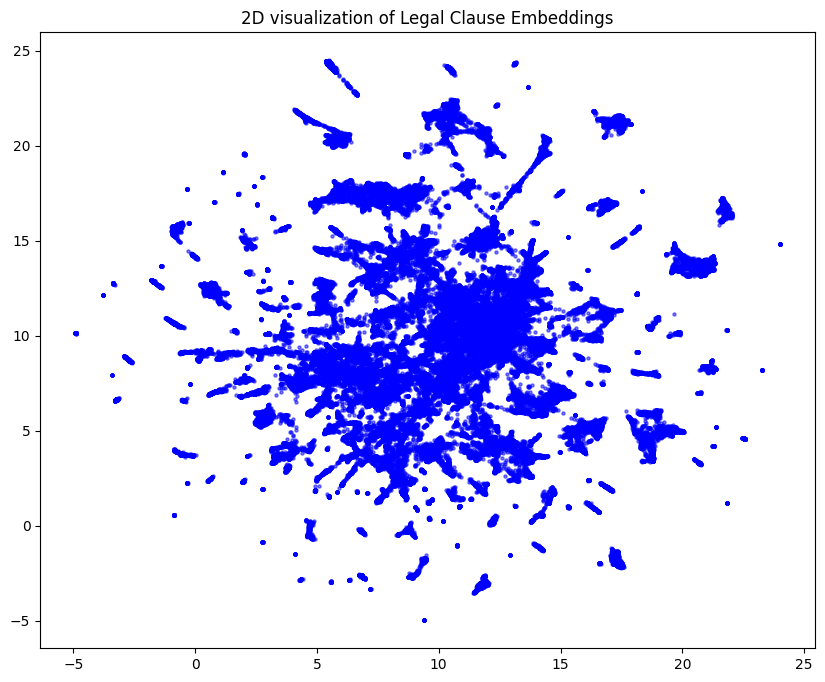

In [17]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="cosine", random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:,0], embedding_2d[:,1], c='blue', alpha=0.5, s=5)
plt.title("2D visualization of Legal Clause Embeddings")
plt.show()


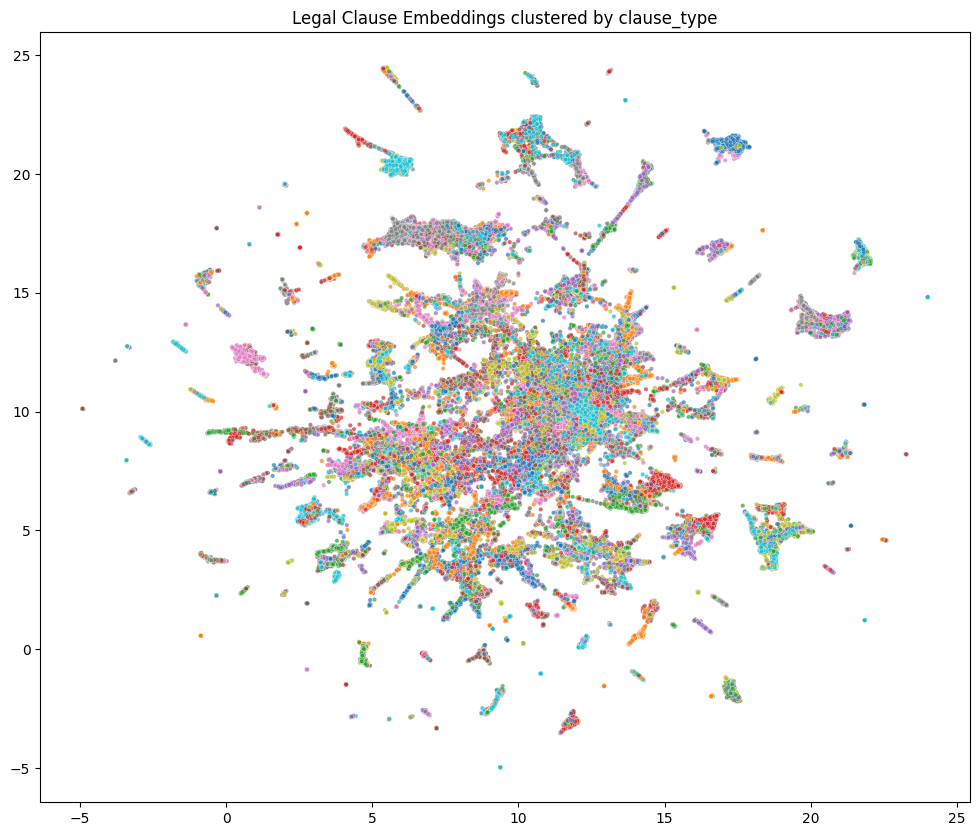

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=embedding_2d[:,0], y=embedding_2d[:,1],
    hue=clause_types, palette="tab10",
    alpha=0.7, s=10, legend=False
)
plt.title("Legal Clause Embeddings clustered by clause_type")
plt.show()


In [30]:
import plotly.express as px

fig = px.scatter(
    x=embedding_2d[:,0], y=embedding_2d[:,1],
    color=clause_types,
    hover_data={"clause": clauses}
)
fig.show()

ModuleNotFoundError: No module named 'plotly'